In [4]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [5]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [6]:
"""
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        # Returns a random choice of the available actions

        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards
"""

'\nclass RandomAgent:\n    def __init__(self, env, num_episodes):\n        self.action_space = [1, 2, 3, 4]\n        self.env = env\n        self.num_episodes = num_episodes\n\n    def act(self):\n        # Returns a random choice of the available actions\n\n        return np.random.choice(self.action_space)\n\n    def learn(self):\n        rewards = []\n        \n        for _ in range(self.num_episodes):\n            cumulative_reward = 0 # Initialise values of each game\n            state = self.env.reset()\n            done = False\n            while not done: # Run until game terminated\n                action = self.act() \n                next_state, reward, done, info = self.env.step(action)\n                cumulative_reward += reward\n                state = next_state\n            rewards.append(cumulative_reward)\n\n        return rewards\n'

You need to complete the learn() method of the following class to implement your RL algorithm.

In [7]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def act(self, state, is_training = True):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon and is_training:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self):
        """Updates Q-values iteratively.
        # TODO: Update Q-values
        Using Q-learning algorithm from lecture notes:

        new_q_value = current_q_value + self.alpha * ((reward + self.gamma * max_future_q_value) - current_q_value)

        Refer to Lectuere Slides: AY24/25 SEM_1 SC3000 Module 5_Reinforcement Learning slides 21

        """
        rewards = []
        
        for _ in range(self.num_episodes):
          
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                

                action = self.act(state) 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward

                # Get old Q-value
                current_q_value = self.q_table[state][action]

                # Max Q-value for next_state
                max_future_q_value = max(self.q_table[next_state].values())

                # Update Q-value using Q-learning formula
                new_q_value = current_q_value + self.alpha * ((reward + self.gamma * max_future_q_value) - current_q_value)

                # Updates new Q-value into the q_table
                self.q_table[state][action] = new_q_value

                state = next_state

            rewards.append(cumulative_reward)

        return rewards


Here is the game interface where you can manually move the agent.

In [8]:
"""
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')
"""

'\nenv = CliffBoxGridWorld(render=True)\nenv.reset()\nenv.print_world()\ndone = False\nrewards = []\n\nwhile not done:\n    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))\n    state, reward, done, info = env.step(action)\n    rewards.append(reward)\n    print(f\'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}\')\n    env.print_world()\n\nprint(f\'rewards: {sum(rewards)}\')\nprint(f\'action history: {env.action_history}\')\n'

Example code to step random agent in the environment.

In [9]:
"""
Learning curve for random agent in the environment


# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

"""

'\nLearning curve for random agent in the environment\n\n\n# Initialize the environment and agent\nenv = CliffBoxGridWorld()\nagent = RandomAgent(env, num_episodes=1000)\nrewards = agent.learn()\n\n# Plot the learning curve\nplt.plot(rewards)\n\n'

Train your own agent!

Success rate: 0.6195
Total time taken: 24.9


Text(0.5, 1.0, 'Learning Curve')

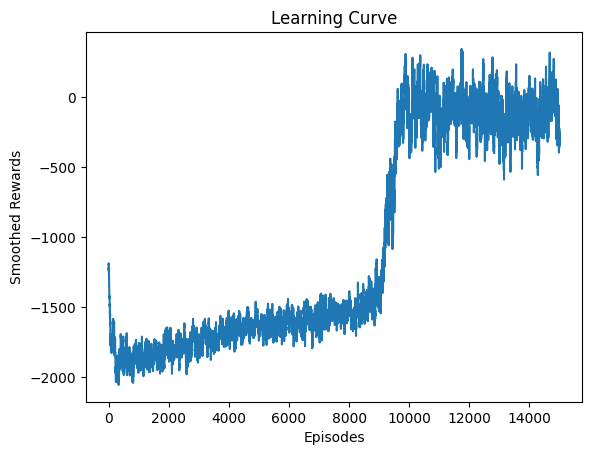

In [10]:
import time

start = time.time()
episodes = 15000 # number of episodes 

env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=episodes)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

time_taken = time.time() - start
# Print total time taken to 1dp
print(f"Total time taken: {round(time_taken,1)}")

# Plot the learning curve
plt.plot(smoothed)

# labelling titles, x-axis and y-axis
plt.xlabel('Episodes')
plt.ylabel('Smoothed Rewards')
plt.title('Learning Curve')

You need to complete the following method to visualize your training results.

In [13]:
import pprint

"""
# TODO: calculate value function and policy

Policy function is to get the best action for each state, getting a collection of such q_values

Value function is to get the average of these q_values to represent the value of the agent's state

Refer to Lectuere Slides: AY24/25 SEM_1 SC3000 Module 5_Reinforcement Learning slides 9-10

"""

def visualize(agent):
    q_table = agent.q_table
    v_table = {}
    policy = {}

    # Iterating over each state and its corresponding q_values in the q_table
    for key, q_values in q_table.items():
        
        
        # self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}
        agent_position = key[0:2]

        # Initialize agent position as empty list if not already in v_table
        if agent_position not in v_table:
            v_table[agent_position] = []
        
        # Get best possible action by selecting the action with the highest q_value
        # from the list of all possible actions from this state
        actions = list(q_values.keys())
        best_action = actions[np.argmax([q_values[action] for action in actions])]

        # update the best action in the policy for this state
        policy[key] = best_action

        # Append the q_value for the best action its corresponding v_table[agent_position]
        v_table[agent_position].append(q_values[best_action])

    # Calculate the average value for each agent's position in v_table
    for agent_position, values in v_table.items():
        v_table[agent_position] = np.mean(values)

    # Printing total state space
    state_num = len(q_table)
    print(f"State space: {state_num}")

    # Visualize v_table and Learned policy
    visualize_v_table(v_table, agent.env)
    visualize_policy(q_table, agent.env)

    return v_table, policy

# Function for visualization v_table
def visualize_v_table(v_table,env):
    V_table = {}
    print("V table: ")

    # Iterate over the rows of the environment
    for y in range(env.world_height):
        # Initialize each row as an empty list
        V_table[y] = []

        # Collects all the states from v_table where y-coordinate matches the current row
        keys = [key for key in v_table if key[0] == y]
        
        # Process the states from left to right,
        # appending it to the V_table as a 2dp float
        for key in sorted(keys):
            V_table[y].append(round(float(v_table[key]),2))
        print(f"{y} {V_table[y]}")

    return V_table

def visualize_policy(q_table, env):
    print("Learned policy: ")

    env = CliffBoxGridWorld(render=True)
    state = env.reset()
    env.print_world()

    done = False
    rewards = []
    states = []

    while not done:
        # Gets best action from the current state based on q_values in q_table
        best_action = np.argmax([q_table[state][i] for i in range(1,5)])
        action_list = list(q_table[state].keys())
        action = action_list[best_action]

        # Take the action and append rewards and states 
        state, reward, done, info = env.step(action)
        rewards.append(reward)
        states.append(state)

        # Print the step, state, actions, and reward for each Learned policy step
        print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
        env.print_world()

    # Print cumulative rewards, action history, and optimal state transition
    print(f'Cumulative rewards: {sum(rewards)}')
    pp = pprint.PrettyPrinter(compact=True,width=60)
    pp.pprint(f'Action history: {env.action_history}')
    pp.pprint(f"Optimal state transition: {states}")

In [15]:
"""
Print out the V table, Learned policy, cumulative rewards, action history, and optimal state transition
"""

v_table, policy = visualize(agent)

State space: 7056
V table: 
0 [-27.52, -25.1, -23.73, -23.76, -28.21, -20.74, 0.0, 0.0, -25.94, -13.91, -10.62, -4.56, -12.2, -2.48]
1 [-22.62, -17.39, -18.47, -20.03, -15.27, -20.26, 0.0, 0.0, -14.51, -9.8, -7.75, -1.82, -3.62, -2.31]
2 [-27.58, -16.66, -11.21, 0.0, -11.89, -15.09, 0.0, 0.0, -19.24, -12.87, -8.34, -3.52, 0.0, -11.94]
3 [-24.4, -19.77, -22.07, 0.0, -22.14, -18.62, 0.0, -22.42, -10.56, 3.31, -7.48, 0.0, 0.0, -22.24]
4 [-18.67, -20.93, -23.05, 0.0, -15.36, -16.01, -14.23, -15.64, -13.02, -8.21, -11.38, 0.0, 0.0, -21.07]
5 [-29.87, -23.8, -27.64, 0.0, -25.81, -24.32, -22.2, -15.24, -15.77, -21.25, -10.77, 0.0, 0.0, -20.29]
Learned policy: 
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_'

C:\Users\randy\AppData\Local\Temp\ipykernel_13560\1052265603.py:55: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  self.world = np.chararray((self.world_height, self.world_width))



Evaluate the agent without exploration

In [20]:
"""
Agent goes through 1000 games of the CliffBoxGridWorld 
"""
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(f"Number of successful runs: {success}")
print(f"Total number of runs: {total_run}")
print(f"Success rate: {success/total_run}")

C:\Users\randy\AppData\Local\Temp\ipykernel_13560\1052265603.py:55: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  self.world = np.chararray((self.world_height, self.world_width))


Number of successful runs: 1000
Total number of runs: 1000
Success rate: 1.0


Evaluate the agent with exploration and visualization

In [33]:
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

# Convert np.int64 values to regular Python integers before printing
clean_action_history = [int(action) for action in env.action_history]

print(f'rewards: {sum(rewards)}')
print(f'action history: {clean_action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 0, 4, 1), actions: 2, reward: -15
Action: 2
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 2, state: (5, 1, 4, 1), actions: 4, reward: -14
Acti

C:\Users\randy\AppData\Local\Temp\ipykernel_13560\1052265603.py:55: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  self.world = np.chararray((self.world_height, self.world_width))
